# Lab 6: Convolutional Neural Networks

### Katherine Wirskye, Lucas Li, Ethan Li, and Kaylie Nguyen (5000-level students)

Link to dataset: https://www.kaggle.com/datasets/msambare/fer2013

## Preparation

### Processing Images

In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # so that I don't use GPU
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable all GPUs

import numpy as np
import matplotlib.pylab as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import Precision, Recall

In [7]:
# locate directories
folder = "allimages"

image_directories = [
    os.path.join(folder, "angry"),
    os.path.join(folder, "disgust"),
    os.path.join(folder, "fear"),
    os.path.join(folder, "happy"),
    os.path.join(folder, "neutral"),
    os.path.join(folder, "sad"),
    os.path.join(folder, "surprise")
]

# function to get image paths and the emotion label
def get_image_paths_and_labels(image_directories):
    image_paths = [] #stores image paths
    labels = [] #stores labels

    # goes through each of the 7 directories 
    for i, directory in enumerate(image_directories):
        emotion_label = os.path.basename(directory) # captures the emotion label
        # goes through each image in each directory
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(directory, filename)) #appends image path to list
                labels.append(emotion_label) # appends emotion label to list

    return image_paths, labels

# gets image path and label for training and testing set
image_paths, image_labels = get_image_paths_and_labels(image_directories)

print("Number of images:", len(image_paths))
print("Number of labels:", len(image_labels))

Number of images: 35685
Number of labels: 35685


In [9]:
def load_and_preprocess_images(image_paths, img_width, img_height):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array /= 255.0 # added this normalization
        images.append(img_array)
    return np.array(images)

img_width = 48
img_height = 48

X = load_and_preprocess_images(image_paths, img_width, img_height)

label_encoder = LabelEncoder()

# Fit and transform the labels for training data
labels_encoded = label_encoder.fit_transform(image_labels)

# Convert the encoded labels to one-hot encoded vectors
y = to_categorical(labels_encoded)

### Performance Metric

Although we initially considered using accuracy as our evaluation metric, we decided it would not be representative of our model's performance because our dataset is imbalanced. For example, there are less than 600 images classified as disgust whereas the happiness category has over 8000 images. In an unbalanced dataset, some emotions might overshadow or dominate others especially if they occur more often, so a model can achieve higher accuracy by predicting the dominant label. This means that accuracy is a misleading evaluation of the model's performance. 

To address this, we are using the F1 score, which combines precision and recall into one metric. In this business case, precision is the proportion of images predicted to belong to a specific emotion that are actually labeled correctly with that emotion, while recall is the proportion of actual instances of a given emotion that are correctly identified by the model. Third parties using the model (likley to assess consumer satisfaction/emotions) should be interested in both of these metrics. The F1 score uses precision and recall to make a better assessment of the model's ability to make correct predictions while avoiding false positives and false negatives. Furthermore, the F1 score is superior to accuracy for this task because it evaluates the model’s performance for all classes, even the underrepresented ones, which promotes a more holistic view of its effectiveness. Unlike accuracy, which treats all predictions equally, the F1 score is particularly sensitive to the trade-off between false positives and false negatives, ensuring the model is not biased toward dominant classes.

### Data Splitting Method

We are implementing the 10 fold stratified cross validation method for our emotion classification model to ensure that the training and validation sets are representative of the entire dataset. Stratified cross-validation maintains the proportion of each class in both the training and validation sets, which is especially important for imbalanced dataset. In our case, the dataset contains images of seven primary emotions, and stratification helps to prevent scenarios where one fold might have an overrepresentation or underrepresentation of certain emotions, especially considering that certain emotion categories have more images than others. This ensures that each fold provides a reliable evaluation of the model's ability to generalize across all classes, resulting in more consistent and unbiased performance metrics.

Stratified 10-fold cross-validation is particularly appropriate for our convolutional neural network because it allows us to make the best use of our data while ensuring that the model does not overfit to any one portion of the dataset. Each fold gives the model a unique training set while still using all the data for validation at some point. This helps the model learn generalizable features and better reflects how the model will perform on our testing data. The use of cross-validation also reduces the risk of overfitting, as the model's performance is evaluated multiple times on different data splits, providing a more accurate estimate of its true performance.

Finally, the chosen method mirrors how our algorithm would be used in practice. By training on 90% of the data in each fold and evaluating on 10%, we assume that our model can be trained on very large quantities of data. This assumption makes sense given that images of people's faces are easily accessible through online media and are not necesarily a scarce resource. Furthermore, it is not unrealistic to assume that each emotion will be represented in the real world to a similar degree that the emotion is represented in the training data (with common emotions like happiness appearing more than disgust), so stratification is roughly consisent with a real-world evaluation situation.

In [10]:
# define the 10-fold stratified cross validation
split_no=10
skf = StratifiedKFold(n_splits=split_no, shuffle=True, random_state=1)

## Modeling

### Data Expansion

The chosen data augmentation techniques—random horizontal flip, random rotation, random translation, and random zoom—are appropriate for our emotion image dataset because they introduce variability in the images without altering their core features. Emotion recognition may rely on small differences such as facial expressions and body language, and small changes in the orientation or position of the face in an image can occur in the real-world. Random horizontal flip simulates different perspectives of the person, helping the model become less sensitive to the direction in which the person's face is facing. Random rotation enables the model to learn to recognize emotions even when the face is rotated, accounting for variations in head tilt or camera angles. This is really important in the real-world where the orientation of a person will certainly vary.

Similarly, random translation and random zoom add further diversity by shifting the face within the frame and altering its scale. These transformations mimic real-world variations, such as the person's movement or different focal lengths of cameras. Random translation helps the model recognize emotions even when the person's position shifts within the image, while random zoom simulates the effect of varying distances between the camera and the face. These augmentations help prevent the model from overfitting to specific image features, making it more generalizable when encountering new, unseen data in emotion recognition tasks. These augmentations make it so that our model can better handle minute differences in facial expressions within images. 

(The data expansion will happen in each of the models below).


### Model 1

Our first model includes four convolutional layers. The initial convolutional layers use 64 filters with 3×3 kernels to capture low-level features such as edges, followed by max-pooling to downsample and batch normalization to stabilize training. As the layers progress, the filter count increases to 128 and then 256, enabling the model to recognize more complex patterns and abstract features, while additional max-pooling reduces spatial dimensions to make the data manageable for the fully connected layers. 

There are also four dense layers in this model. Dropout layers are incorporated between the dense layers, with 50% and 25% dropout rates, to reduce overfitting by preventing the model from relying too heavily on specific neurons. Finally, the model uses the Adam optimizer and the categorical cross-entropy loss function.

In [48]:
# for tracking performance
training_results_model1_1 = []
testing_results_model1_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay!
    input_shape = (img_width, img_height, 3)

    model1_1 = Sequential([

        # data expansion and augmentation
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    # training the model
    history = model1_1.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # track variables for the f1 score and loss for training data and validation data
    training_results_model1_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_precision': history.history['val_precision'],
        'val_recall': history.history['val_recall'],

    })

    # Evaluate the model on the test data
    y_test_pred = model1_1.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model1_1.append(test_f1)

112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.48999247494630443
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.5055235800240482
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.4865892924007601
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.48790170076282713
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.49945825442068864
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.5026773852775398
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.5242652983380943
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.5043149173879081
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.5173980410931661
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.5154186986640253


##### Loss Across Training Iterations

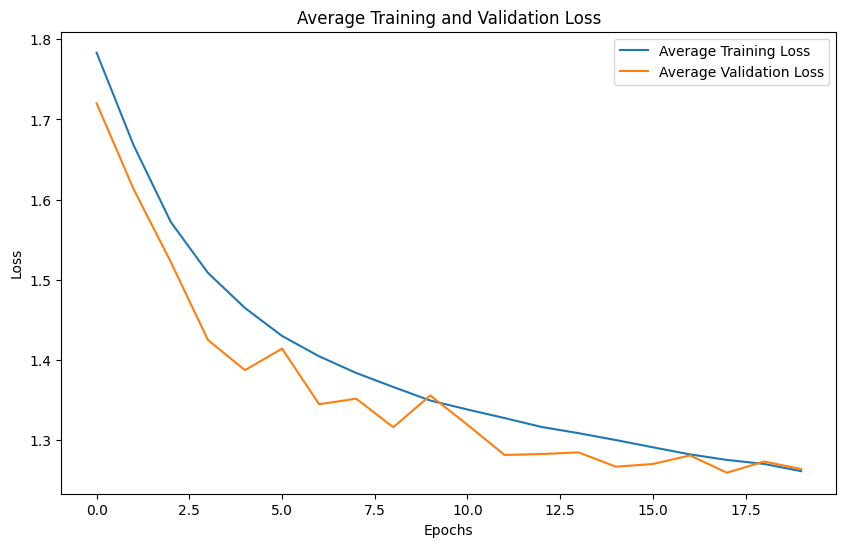

In [49]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_1 = []
avg_val_loss1_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_1]
    
    avg_loss1_1.append(np.mean(epoch_loss))
    avg_val_loss1_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_1, label='Average Training Loss')
plt.plot(avg_val_loss1_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

##### Performance Across Training Iterations

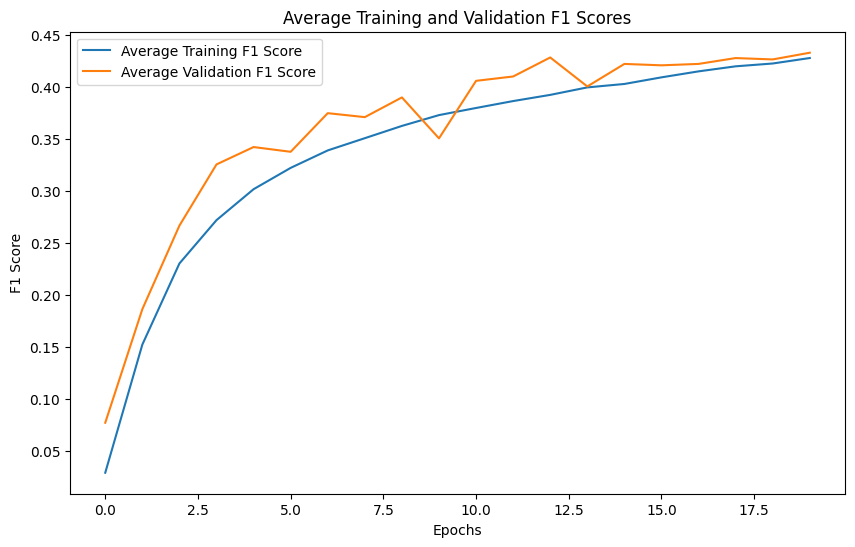

In [50]:
# Initialize lists to store the average training f1 and validation f1 across all instances
avg_metric1_1 = []
avg_val_metric1_1 = []

# Calculate the average training f1 and validation f1 for each epoch
for epoch in range(num_epochs):
    # access precision and recall data
    epoch_precision = [result['precision'][epoch] for result in training_results_model1_1]
    epoch_val_precision = [result['val_precision'][epoch] for result in training_results_model1_1]

    epoch_recall = [result['recall'][epoch] for result in training_results_model1_1]
    epoch_val_recall = [result['val_recall'][epoch] for result in training_results_model1_1]

    avg_precision = np.mean(epoch_precision)
    avg_val_precision = np.mean(epoch_val_precision)
    avg_recall = np.mean(epoch_recall)
    avg_val_recall = np.mean(epoch_val_recall)
    
    # manually compute F1 score from the average precision and recall per epoch
    epoch_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-7)
    epoch_val_f1 = 2 * (avg_val_precision * avg_val_recall) / (avg_val_precision + avg_val_recall + 1e-7)
    
    avg_metric1_1.append(epoch_f1)
    avg_val_metric1_1.append(epoch_val_f1)

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_metric1_1, label='Average Training F1 Score')
plt.plot(avg_val_metric1_1, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Scores')
plt.legend()
plt.show()

##### Testing Performance

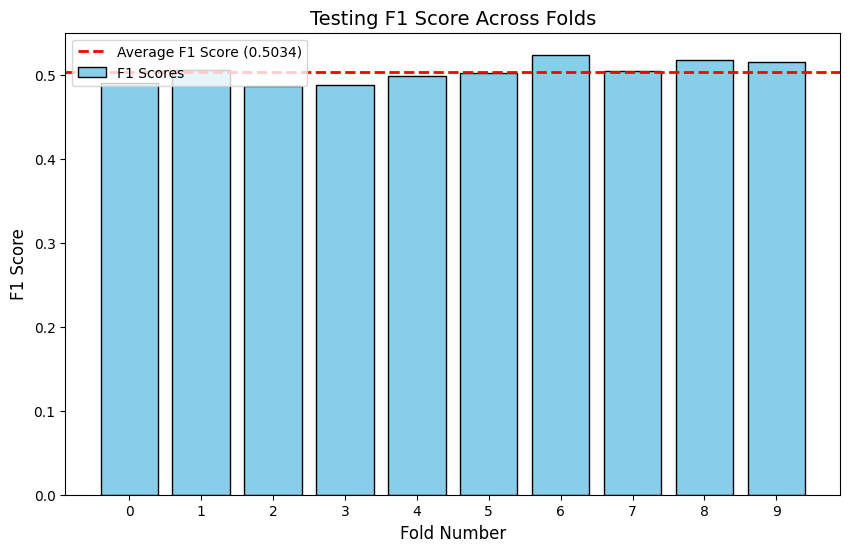

Average F1 Score:  0.5033539643315362
Standard Deviation:  0.012246219201959943


In [51]:
# Calculate the average testing F1 score and standard deviation
average_f1_score1_1 = np.mean(testing_results_model1_1)
std_f1_score1_1 = np.std(testing_results_model1_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_1)), testing_results_model1_1, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score1_1, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_1)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score1_1)
print("Standard Deviation: ", std_f1_score1_1)


### Model 1 with Changed Parameters

This model increases the MaxPooling pool size from (2,2) to (3,3).

In [52]:
# for tracking performance
training_results_model1_2 = []
testing_results_model1_2 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay! (parameters modified though)
    input_shape = (img_width, img_height, 3)

    model1_2 = Sequential([

        # data expansion and augmentation
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    # traing the model
    history = model1_2.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)

    # track variables for the f1 score and loss for training data and validation data
    training_results_model1_2.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_precision': history.history['val_precision'],
        'val_recall': history.history['val_recall'],

    })

    # Evaluate the model on the test data
    y_test_pred = model1_2.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model1_2.append(test_f1)

112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4666577401143797
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.4713155083236991
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4873887541175337
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4946248745855223
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.49138366132164457
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.48502852163202564
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.48479760765333096
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.5163175603017902
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.4533173538254301
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.46197164131009044


#### Loss Across Training Iterations

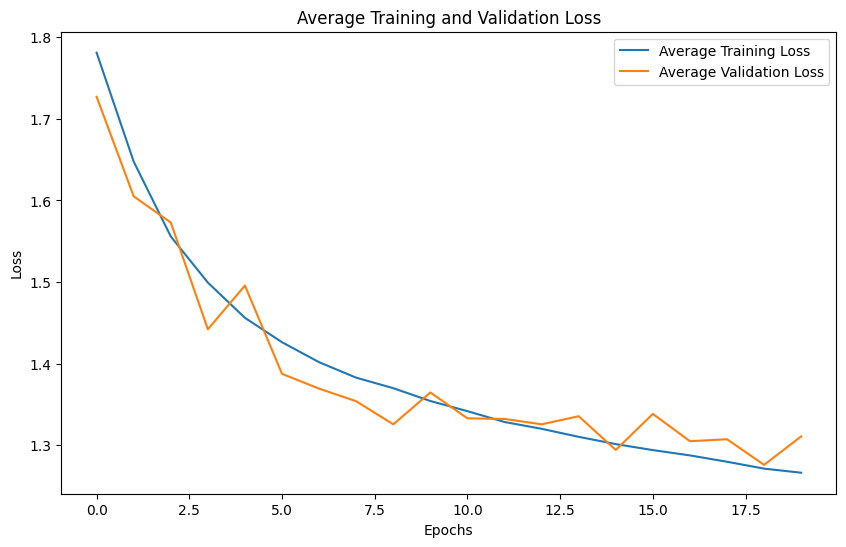

In [53]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_2[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_2 = []
avg_val_loss1_2 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_2]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_2]
    
    avg_loss1_2.append(np.mean(epoch_loss))
    avg_val_loss1_2.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_2, label='Average Training Loss')
plt.plot(avg_val_loss1_2, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

#### Performance Across Training Iterations

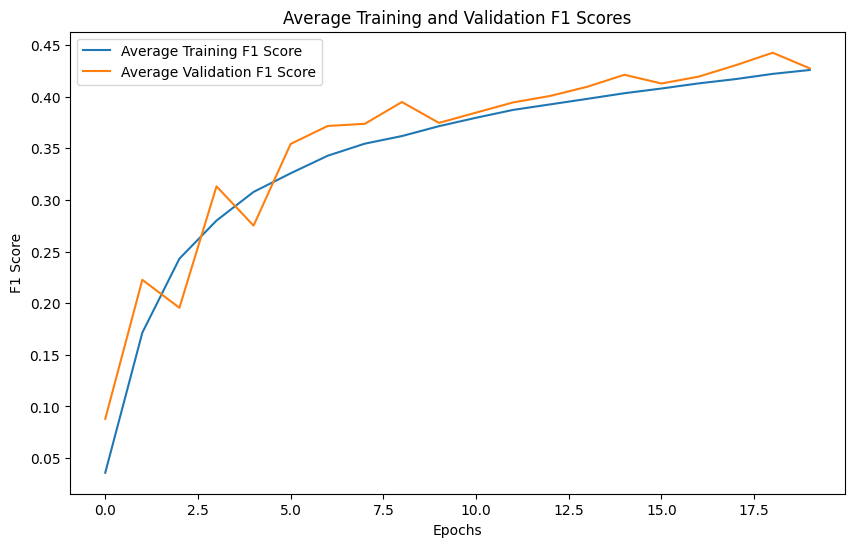

In [54]:
# Initialize lists to store the average training f1 and validation f1 across all instances
avg_metric1_2 = []
avg_val_metric1_2 = []

# Calculate the average training f1 and validation f1 for each epoch
for epoch in range(num_epochs):
    # access precision and recall data
    epoch_precision = [result['precision'][epoch] for result in training_results_model1_2]
    epoch_val_precision = [result['val_precision'][epoch] for result in training_results_model1_2]

    epoch_recall = [result['recall'][epoch] for result in training_results_model1_2]
    epoch_val_recall = [result['val_recall'][epoch] for result in training_results_model1_2]

    avg_precision = np.mean(epoch_precision)
    avg_val_precision = np.mean(epoch_val_precision)
    avg_recall = np.mean(epoch_recall)
    avg_val_recall = np.mean(epoch_val_recall)
    
    # manually compute F1 score from the average precision and recall per epoch
    epoch_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-7)
    epoch_val_f1 = 2 * (avg_val_precision * avg_val_recall) / (avg_val_precision + avg_val_recall + 1e-7)
    
    avg_metric1_2.append(epoch_f1)
    avg_val_metric1_2.append(epoch_val_f1)

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_metric1_2, label='Average Training F1 Score')
plt.plot(avg_val_metric1_2, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Scores')
plt.legend()
plt.show()

#### Testing Performance

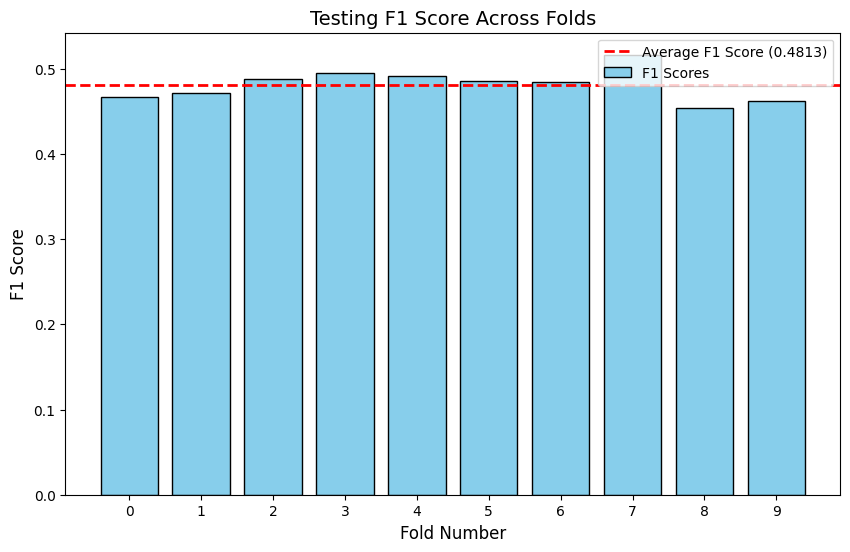

Average F1 Score:  0.4812803223185447
Standard Deviation:  0.017433777589718227


In [55]:
# Calculate the average testing F1 score and standard deviation
average_f1_score1_2 = np.mean(testing_results_model1_2)
std_f1_score1_2 = np.std(testing_results_model1_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_2)), testing_results_model1_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score1_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score1_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score1_2)
print("Standard Deviation: ", std_f1_score1_2)

### Model 2

This model is heavily based off of the model from the in-class demos. This model has fewer filters per layer (i.e. 24) and only two convolutional layers. This model also incorporates MaxPooling. 

The dense layer architecture is relatively similar to Model 1, although this model does not use dropout. Finally, this model uses the Adam optimizer and the categorical cross-entropy loss function, similar to Model 1.

In [56]:
# for tracking performance
training_results_model2_1 = []
testing_results_model2_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # changes: 
    # 1. Baseline: 2 conv layers and 2 output layers
    cnn1 = Sequential()

    # same data augmentation as all the others
    cnn1.add(RandomFlip("horizontal"))
    cnn1.add(RandomRotation(0.10))
    cnn1.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
    cnn1.add(RandomZoom(height_factor=0.1, width_factor=0.1))

    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(2, 2), ) )
        
    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(1024, activation='relu') )
    cnn1.add( Dense(512, activation='relu') )
    cnn1.add( Dense(128, activation='relu') )
    cnn1.add( Dense(7, activation='softmax') )

    # Let's train the model 
    cnn1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    input_shape = [None, 48,48,3]
    cnn1.build(input_shape)

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = cnn1.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=20, 
            shuffle=True, verbose=0,
            validation_data=(X_val,y_val))

    # track variables for the f1 score and loss for training data and validation data
    training_results_model2_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_precision': history.history['val_precision'],
        'val_recall': history.history['val_recall'],
    })

    # Evaluate the model on the test data
    y_test_pred = cnn1.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model2_1.append(test_f1)

112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4901552917217961
112/112 [==============================] - 1s 8ms/step
Test F1 Score: 0.4981930378149913
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.507310167404438
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.5027581222152814
112/112 [==============================] - 918s 8s/step
Test F1 Score: 0.49756501438430445
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.49980343698236274
112/112 [==============================] - 1s 5ms/step
Test F1 Score: 0.4981845751157729
112/112 [==============================] - 1s 5ms/step
Test F1 Score: 0.4974569383133204
112/112 [==============================] - 1s 5ms/step
Test F1 Score: 0.5047719033462639
112/112 [==============================] - 1s 5ms/step
Test F1 Score: 0.5205762722240462


#### Loss Across Training Iterations

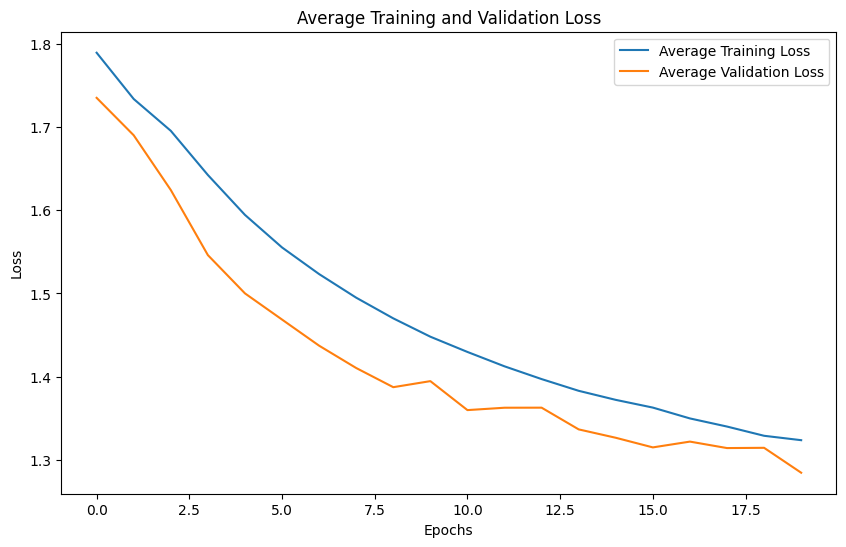

In [57]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_1 = []
avg_val_loss2_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_1]
    
    avg_loss2_1.append(np.mean(epoch_loss))
    avg_val_loss2_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_1, label='Average Training Loss')
plt.plot(avg_val_loss2_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

#### Performance Across Training Iterations

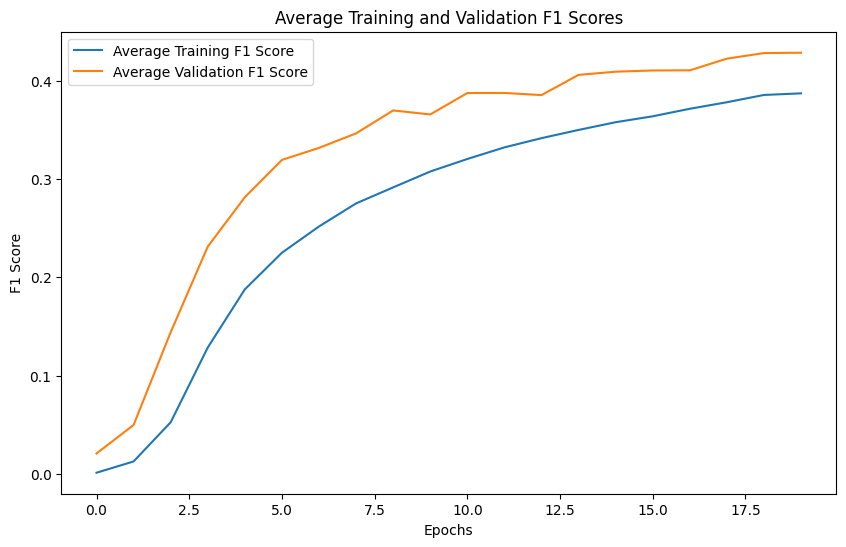

In [58]:
# Initialize lists to store the average training f1 and validation f1 across all instances
avg_metric2_1 = []
avg_val_metric2_1 = []

# Calculate the average training f1 and validation f1 for each epoch
for epoch in range(num_epochs):
    # access precision and recall data
    epoch_precision = [result['precision'][epoch] for result in training_results_model2_1]
    epoch_val_precision = [result['val_precision'][epoch] for result in training_results_model2_1]

    epoch_recall = [result['recall'][epoch] for result in training_results_model2_1]
    epoch_val_recall = [result['val_recall'][epoch] for result in training_results_model2_1]

    avg_precision = np.mean(epoch_precision)
    avg_val_precision = np.mean(epoch_val_precision)
    avg_recall = np.mean(epoch_recall)
    avg_val_recall = np.mean(epoch_val_recall)
    
    # manually compute F1 score from the average precision and recall per epoch
    epoch_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-7)
    epoch_val_f1 = 2 * (avg_val_precision * avg_val_recall) / (avg_val_precision + avg_val_recall + 1e-7)
    
    avg_metric2_1.append(epoch_f1)
    avg_val_metric2_1.append(epoch_val_f1)

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_metric2_1, label='Average Training F1 Score')
plt.plot(avg_val_metric2_1, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Scores')
plt.legend()
plt.show()

#### Testing Performance

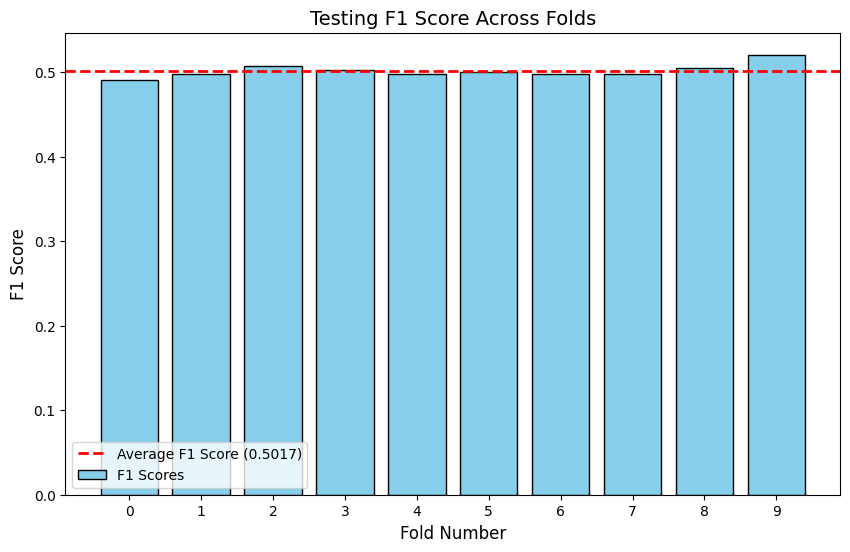

Average F1 Score:  0.5016774759522578
Standard Deviation:  0.007713460220663036


In [59]:
# Calculate the average testing F1 score and standard deviation
average_f1_score2_1 = np.mean(testing_results_model2_1)
std_f1_score2_1 = np.std(testing_results_model2_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_1)), testing_results_model2_1, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score2_1, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score2_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_1)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score2_1)
print("Standard Deviation: ", std_f1_score2_1)

### Model 2 with Changed Parameters

This model increases the MaxPooling pool size from (2,2) to (3,3) and increases the kernel size from (3,3) to (5,5).

In [60]:
# for tracking performance
training_results_model2_2 = []
testing_results_model2_2 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # changes: 
    #    1. Baseline: 2 conv layers and two output layers
    cnn1 = Sequential()

    # data augmentation 
    cnn1.add(RandomFlip("horizontal"))
    cnn1.add(RandomRotation(0.10))
    cnn1.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
    cnn1.add(RandomZoom(height_factor=0.1, width_factor=0.1))

    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(5,5), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(3, 3), ) )
        
    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(1024, activation='relu') )
    cnn1.add( Dense(512, activation='relu') )
    cnn1.add( Dense(128, activation='relu') )
    cnn1.add( Dense(7, activation='softmax') )

    # Let's train the model 
    cnn1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    input_shape = [None, 48,48,3]
    cnn1.build(input_shape)

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = cnn1.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=20, 
            shuffle=True, verbose=0,
            validation_data=(X_val,y_val))

    # track variables for the f1 score and loss for training data and validation data
    training_results_model2_2.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_precision': history.history['val_precision'],
        'val_recall': history.history['val_recall'],
    })

    # Evaluate the model on the test data
    y_test_pred = cnn1.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate the F1 score for the test set
    test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
    print("Test F1 Score:", test_f1)

    testing_results_model2_2.append(test_f1)

112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.48526760871093116
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.48099384665011424
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.46389534339695115
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.4604539809152615
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.4629373639557951
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4517581059388051
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.47430731621164995
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4832300063182277
112/112 [==============================] - 1s 7ms/step
Test F1 Score: 0.4965971288930347
112/112 [==============================] - 1s 6ms/step
Test F1 Score: 0.47668696978052094


#### Loss Across Training Iterations

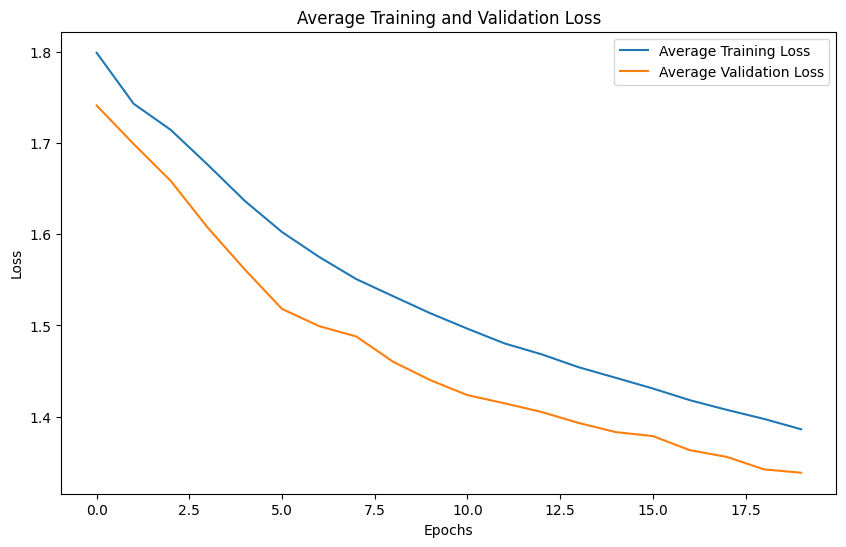

In [61]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_2[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_2 = []
avg_val_loss2_2 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_2]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_2]
    
    avg_loss2_2.append(np.mean(epoch_loss))
    avg_val_loss2_2.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_2, label='Average Training Loss')
plt.plot(avg_val_loss2_2, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

#### Performance Across Training Iterations

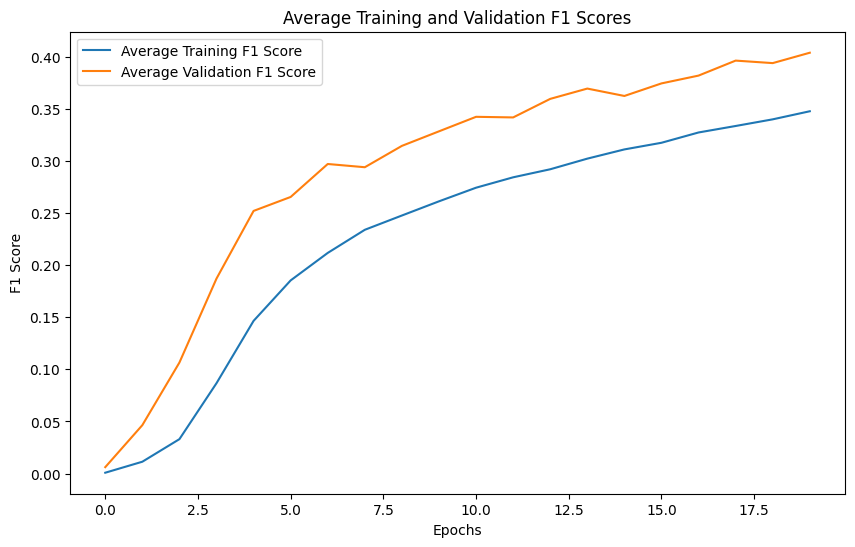

In [62]:
# Initialize lists to store the average training f1 and validation f1 across all instances
avg_metric2_2 = []
avg_val_metric2_2 = []

# Calculate the average training f1 and validation f1 for each epoch
for epoch in range(num_epochs):
    # access precision and recall data
    epoch_precision = [result['precision'][epoch] for result in training_results_model2_2]
    epoch_val_precision = [result['val_precision'][epoch] for result in training_results_model2_2]

    epoch_recall = [result['recall'][epoch] for result in training_results_model2_2]
    epoch_val_recall = [result['val_recall'][epoch] for result in training_results_model2_2]

    avg_precision = np.mean(epoch_precision)
    avg_val_precision = np.mean(epoch_val_precision)
    avg_recall = np.mean(epoch_recall)
    avg_val_recall = np.mean(epoch_val_recall)
    
    # manually compute F1 score from the average precision and recall per epoch
    epoch_f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-7)
    epoch_val_f1 = 2 * (avg_val_precision * avg_val_recall) / (avg_val_precision + avg_val_recall + 1e-7)
    
    avg_metric2_2.append(epoch_f1)
    avg_val_metric2_2.append(epoch_val_f1)

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_metric2_2, label='Average Training F1 Score')
plt.plot(avg_val_metric2_2, label='Average Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Average Training and Validation F1 Scores')
plt.legend()
plt.show()

#### Testing Performance

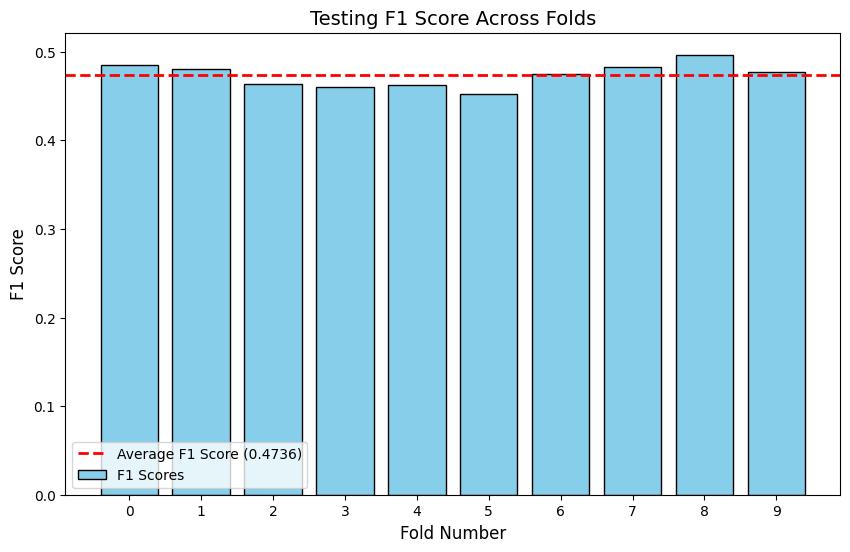

Average F1 Score:  0.4736127670771292
Standard Deviation:  0.012962227394033533


In [63]:
# Calculate the average testing F1 score and standard deviation
average_f1_score2_2 = np.mean(testing_results_model2_2)
std_f1_score2_2 = np.std(testing_results_model2_2)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model2_2)), testing_results_model2_2, color='skyblue', edgecolor='black', label='F1 Scores')

# Plot the average as a horizontal line
plt.axhline(average_f1_score2_2, color='red', linestyle='--', linewidth=2, label=f'Average F1 Score ({average_f1_score2_2:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Testing F1 Score Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model2_2)))

# Show the plot
plt.legend()
plt.show()

# Print average and standard deviation for F1 score
print("Average F1 Score: ", average_f1_score2_2)
print("Standard Deviation: ", std_f1_score2_2)

### Performance Comparison

In [64]:
t = 2.26 / np.sqrt(split_no)

comparisons = [
    ("1_1 vs 1_2", testing_results_model1_1, testing_results_model1_2),
    ("1_1 vs 2_1", testing_results_model1_1, testing_results_model2_1),
    ("1_1 vs 2_2", testing_results_model1_1, testing_results_model2_2),
    ("1_2 vs 2_1", testing_results_model1_2, testing_results_model2_1),
    ("1_2 vs 2_2", testing_results_model1_2, testing_results_model2_2),
    ("2_1 vs 2_2", testing_results_model2_1, testing_results_model2_2),
]

for name, model1, model2 in comparisons:
    # compare model 1 minus model 2
    d = [a - b for a, b in zip(model1, model2)]
    stdtot = np.std(d)
    dbar = np.mean(d)
    print ('Difference of' , name , 'has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)


Difference of 1_1 vs 1_2 has a range of:  0.004670979560397696  to  0.03947630446558539
Difference of 1_1 vs 2_1 has a range of:  -0.0073658419500830415  to  0.010718818708639999
Difference of 1_1 vs 2_2 has a range of:  0.020029024131187637  to  0.03945337037762648
Difference of 1_2 vs 2_1 has a range of:  -0.03547429240399657  to  -0.005320014863429562
Difference of 1_2 vs 2_2 has a range of:  -0.010944609396593885  to  0.026279719879424915
Difference of 2_1 vs 2_2 has a range of:  0.01701387505288785  to  0.03911554269736931


Because each of these 95% confidence intervals contain XXXXXXXX, we XXXXXXC conclude that any of the models are statistically better than the others. Specifically, there is not a statistically significant difference in performance for using a XXXX, XXXXXXXXXXXX, or .

### Multi-Layer Perceptron

In [67]:
# values we need for the plot (we will plot only one of the ten instances of the model)
ex_fpr1 = dict()
ex_tpr1 = dict()
ex_roc_auc1 = dict()
count = 0

# for tracking performance of all 10 splits
micro_aucs1 = []
macro_aucs1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # track the number split we're on, so we can save the data for the first split
    count += 1
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # make a keras MLP
    mlp = Sequential()
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=1, units=1024, activation='relu') )
    mlp.add( Dense(units=512, activation='relu') )
    mlp.add( Dense(units=128, activation='relu') )
    mlp.add( Dense(7) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    mlp.build(input_shape)

    history = mlp.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=8, 
            shuffle=True, verbose=1)

    # Predict probabilities on the test set (needed for ROC curve)
    y_pred_proba = mlp.predict(X_test, verbose=0)  # This gives predicted probabilities for each class
    y_pred_labels = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels

    # find the true labels
    y_true = np.argmax(y_test, axis=1)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 7  # Number of classes

    for i in range(n_classes):
        # For each class, calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute Macro and Micro AUCs
    macro_auc = roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovr")
    micro_auc = roc_auc_score(y_true, y_pred_proba, average="micro", multi_class="ovr")

    # add to list to store
    macro_aucs1.append(macro_auc)
    micro_aucs1.append(micro_auc)

    #save the data for the first split
    if count == 1:
        ex_fpr1 = fpr
        ex_tpr1 = tpr
        ex_roc_auc1 = roc_auc

    # breaking for now so that we don't waste time running it a billion times
    break

Epoch 1/8
287/287 [==============================] - 27s 88ms/step - loss: 2.0466 - accuracy: 0.2499
Epoch 2/8
287/287 [==============================] - 23s 79ms/step - loss: 1.7363 - accuracy: 0.3041
Epoch 3/8
287/287 [==============================] - 23s 80ms/step - loss: 1.6993 - accuracy: 0.3265
Epoch 4/8
287/287 [==============================] - 25s 87ms/step - loss: 1.6753 - accuracy: 0.3442
Epoch 5/8
287/287 [==============================] - 24s 83ms/step - loss: 1.6608 - accuracy: 0.3478
Epoch 6/8
287/287 [==============================] - 23s 79ms/step - loss: 1.6499 - accuracy: 0.3517
Epoch 7/8
287/287 [==============================] - 23s 80ms/step - loss: 1.6414 - accuracy: 0.3534
Epoch 8/8
287/287 [==============================] - 25s 89ms/step - loss: 1.6181 - accuracy: 0.3683


#### Receiver Operating Characteristic Graph

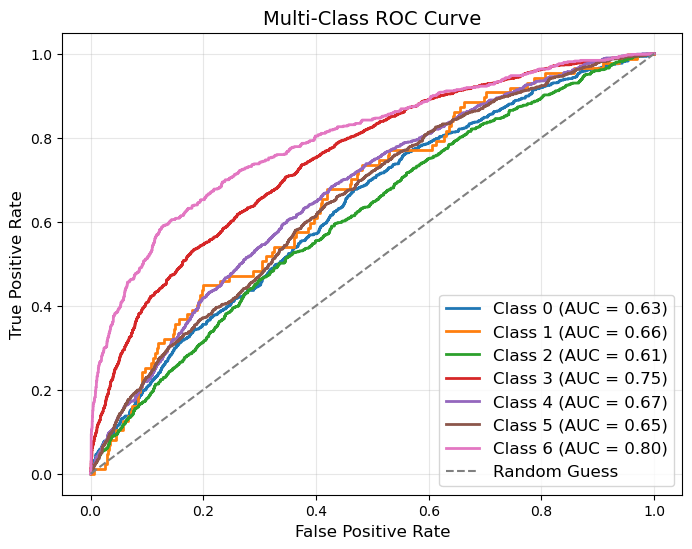

In [68]:
# Plot ROC curve for each class
n_classes = 7

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(ex_fpr1[i], ex_tpr1[i], lw=2, label=f"Class {i} (AUC = {ex_roc_auc1[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Best Performing CNN

In [ ]:
# code to track ROC/AUC for this CNN

#### Receiver Operating Characteristic Graph

In [ ]:
# Plot ROC curve for each class
n_classes = 7

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(ex_fpr2[i], ex_tpr2[i], lw=2, label=f"Class {i} (AUC = {ex_roc_auc2[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Statistical Comparison of AUC

In [ ]:
t = 2.26 / np.sqrt(split_no)

# compare on the basis of micro averaged auc
d = [a - b for a, b in zip(micro_aucs1, micro_aucs2)]
stdtot = np.std(d)
dbar = np.mean(d)
print ('MICRO AVERAGED AUCS:')
print ('Difference of MLP - CNN has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)

# compare on the basis of macro averaged auc
d = [a - b for a, b in zip(macro_aucs1, macro_aucs2)]
stdtot = np.std(d)
dbar = np.mean(d)
print ('MACRO AVERAGED AUCS:')
print('Difference of MLP - CNN has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)

Comparison of MLP to CNN (Make sure plotting correct CNN Performance. Y is generic)

I dont think this will work once we have multiple instances for the 10 folds.

179/179 [==============================] - 3s 17ms/step


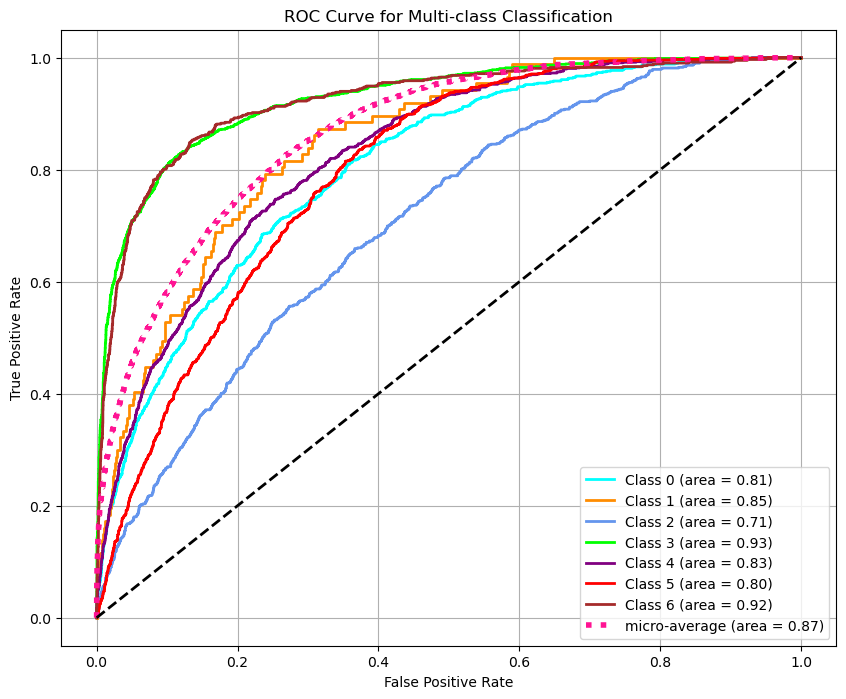

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

#Need to ensure that it is using the y of the model we comapre to
n_classes = 7  # Number of classes (update based on your problem)
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=np.arange(n_classes))
# Get predicted probabilities for the test set
y_pred_prob = model1_1.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

micro_aucs2 = []
macro_aucs2 = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
macro_auc = roc_auc_score(y_test, y_pred_prob, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_test, y_pred_prob, average="micro", multi_class="ovr")

macro_aucs2.append(macro_auc)
micro_aucs2.append(micro_auc)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lime', 'purple', 'red', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [71]:
t = 2.26 / np.sqrt(split_no) 
# compare on the basis of micro averaged auc
d = [a - b for a, b in zip(micro_aucs1, micro_aucs2)]
stdtot = np.std(d)
dbar = np.mean(d)
print ('MICRO AVERAGED AUCS:')
print ('Difference of XXXXXXXXXXx - XXXXXXXXXXx has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)

# compare on the basis of macro averaged auc
d = [a - b for a, b in zip(macro_aucs1, macro_aucs2)]
stdtot = np.std(d)
dbar = np.mean(d)
print ('MACRO AVERAGED AUCS:')
print('Difference of XXXXXXXXXXx - XXXXXXXXX has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)

[0.8671988701562344]
MICRO AVERAGED AUCS:
Difference of Wide & Deep - No Wide has a range of:  -0.1328171361435765  to  -0.1328171361435765
MACRO AVERAGED AUCS:
Difference of Wide & Deep - No Wide has a range of:  -0.15098357899236825  to  -0.15098357899236825


### Exceptional Work

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import tensorflow as tf

# Assuming X is your input image data and y is the one-hot encoded labels
# n_classes = 7 is the number of classes you have in your dataset
n_classes = 7

# Results to track performance
testing_results = []

for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)
    
    # Convert labels into binary format (one-hot encoded)
    y_train_bin = label_binarize(np.argmax(y_train, axis=1), classes=np.arange(n_classes))
    y_val_bin = label_binarize(np.argmax(y_val, axis=1), classes=np.arange(n_classes))

    # Load the pre-trained VGG16 model (exclude the top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Freeze all layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers on top of the VGG16 model
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(7, activation='softmax')(x)  # Adjust for the number of classes in your task


    # Define the complete model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training data
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Print the average testing accuracy across all folds
print(f"Average Validation Accuracy across all folds: {np.mean(testing_results)}")

NameError: name 'X' is not defined

In [ ]:
testing_results=[]
y_test_pred = model.predict(X_test)
y_test_pred_labels = tf.argmax(y_test_pred, axis=1)
y_test_true_labels = tf.argmax(y_test, axis=1)

# Calculate the F1 score for the test set
test_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='weighted')
print("Test F1 Score:", test_f1)

testing_results.append(test_f1)

In [79]:
d = [a - b for a, b in zip(testing_results, testing_results_model1_1)]
stdtot = np.std(d)
dbar = np.mean(d)
print ('Difference of XXXXXXXXXXx - XXXXXXXXXXx has a range of: ', dbar-t*stdtot, ' to ', dbar+t*stdtot)

Difference of XXXXXXXXXXx - XXXXXXXXXXx has a range of:  -0.09942340850830078  to  -0.09942340850830078
